In [1]:
import os
import tensorflow as tf
import pandas
from pandas import read_csv
import numpy as np
import math
import cv2

from keras.optimizers import SGD
from keras.applications.inception_v3 import InceptionV3
from keras import layers
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.layers import Input
from keras import activations
from keras.models import load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import initializers
from keras.models import Sequential, Model

from keras.applications import imagenet_utils 
import numpy as np

import h5py as h5py

from __future__ import division

from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
from vis.utils import utils

import matplotlib.pyplot as plt

# Configure the TF backend session
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))


Using TensorFlow backend.


Downloading the weights:

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2018-08-21 15:45:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.195.80, 2607:f8b0:400a:808::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.195.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  39.6MB/s    in 2.1s    

2018-08-21 15:45:34 (39.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(256, 256, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [23]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called mixed7. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from mixed7:

In [24]:
last_layer = pre_trained_model.get_layer('mixed7')
print 'last layer output shape:', last_layer.output_shape
last_output = last_layer.output


last layer output shape: (None, 14, 14, 768)


Now let's stick a fully connected classifier on top of last_output:

In [25]:
#STEP DECAY LEARNING RATE (LEARNINGG RATE SCHEDULER)
def step_decay(epoch):
   initial_lrate = 0.0001
   drop = 0.5
   epochs_drop = 7.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)

In [26]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
#model = Model(pre_trained_model.input, x)
#rmsprop = RMSprop(lr=0.0, rho=0.9, epsilon=None, decay=0.0)
#model.compile(loss='binary_crossentropy',
 #             optimizer=rmsprop,
  #            metrics=['acc'])



# Configure and compile the model
model = Model(pre_trained_model.input, x)
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [27]:
import os
import zipfile

# local_zip = '/tmp/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# Define our example directories and files
# base_dir = '/tmp/cats_and_dogs_filtered'
base_dir = '/mnt/data/datasets/tvt1182'

train_dir = os.path.join(base_dir, 'chnmcu256train')
validation_dir = os.path.join(base_dir, 'chnmcu256validate')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'Normal')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'TB')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'Normal')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'TB')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)


from keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

train_datagen = ImageDataGenerator(
    rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(256, 256),  # All images will be resized to 256x256
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        # All images will be resized to 256x256
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')



Found 94472 images belonging to 2 classes.
Found 19600 images belonging to 2 classes.


Finally, let's train the model using the features we extracted. We'll train on all 94472 images available, for 30 epochs, and validate on all 19600 test images

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 127, 127, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 127, 127, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [40]:
#Visualize Convolutional Layers
def plot_conv_weights(model, layer_name):
    W = model.get_layer(name=layer_name).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [41]:
plot_conv_weights(pre_trained_model, 'mixed7')

IndexError: list index out of range

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
last_layer


In [44]:
W = pre_trained_model.get_layer(name='mixed10').get_weights()[0]
W.shape

IndexError: list index out of range

In [17]:
pre_trained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks_list,
      verbose=2)

**Further Improving Accuracy with Fine-Tuning**

**In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:
•Fine-tuning should only be attempted after you have trained the top-level classifier with the pretrained model set to non-trainable. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
•Additionally, we fine-tune only the top layers of the pre-trained model rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.**

**All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the mixed7 module—i.e., all layers found after mixed6—and recompile the model:**


In [ ]:
unfreeze = True

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

from keras.optimizers import SGD

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks_list,
      verbose=2)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [10]:
from keras.models import load_model

model.save('tb_model.h5')  # creates a HDF5 file 'tb_model.h5'
del model  # deletes the existing model

In [ ]:
from keras.models import load_model
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
model = load_model('tb_model.h5')
test_dir = os.path.join(base_dir, 'chnmcu256test')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=671,
        class_mode='binary')

test_X, test_Y = next(test_generator)

pred_Y = model.predict(test_X, batch_size = 1, verbose = True)

from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'TB']))

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'Inception-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')


In [ ]:
test_dir = os.path.join(base_dir, 'chnmcu256test')
test_dir = '/mnt/data/datasets/belnormtvt/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=671,
        class_mode='binary')

test_X, test_Y = next(test_generator)

pred_Y = model.predict(test_X, batch_size = 1, verbose = True)

from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'TB']))

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'Inception-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')


In [10]:
 def visualize_class_activation_map(model_path, img_path, output_path):
        model = load_model('tb_model.h5')
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "mixed7")
        get_output = K.function([model.layers[0].input],[final_conv_layer.output,model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]
        print "predictions", predictions
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img) 
        
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer      

In [11]:
visualize_class_activation_map("/mnt/data/keras/google-cats-dogs/tb_model.h5", "/mnt/data/datasets/belnormtvt/test/TB/103.jpg", "/mnt/data/keras/google-cats-dogs")

ValueError: Cannot feed value of shape (1, 3, 256, 256) for Tensor u'input_1_5:0', which has shape '(?, 256, 256, 3)'

In [51]:
original_img = cv2.imread("/mnt/data/datasets/belnormtvt/test/TB/103.jpg", 1)
original_img.shape
2, 0, 1

(256, 256, 3)

In [71]:
img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
img.shape

(1, 3, 256, 256)

In [7]:
model = load_model('tb_model.h5')
old_input = model.pop(0)
new_input = Input(shape=(3, 256, 256), name='image_input')
x = model(new_input)
m = Model(inputs=new_input, outputs=x)
m.save('transfer_model.h5')

AttributeError: 'Model' object has no attribute 'pop'

In [52]:
last_output = last_layer.output
last_output = GlobalAveragePooling2D()(last_output)
#Only for version 2:
last_output= Dense(1024, activation='relu',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

# and a logistic layer
predictions = Dense(1, activation='sigmoid',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

model= Model(inputs=pre_trained_model.input, outputs=predictions)

In [53]:
model = load_model('tb_model.h5')

In [54]:

#With Custom Model#With C 

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')
print("Remove Activation from Last Layer")
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
print("Done. Now Applying changes to the model ...")
model = utils.apply_modifications(model)

Remove Activation from Last Layer
Done. Now Applying changes to the model ...


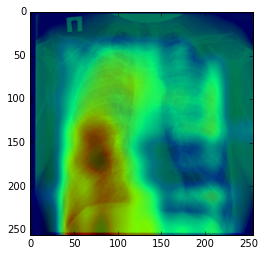

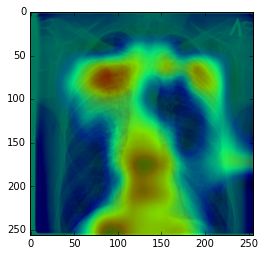

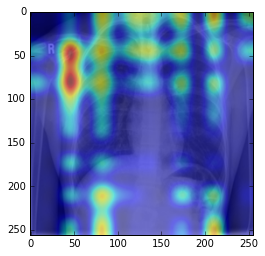

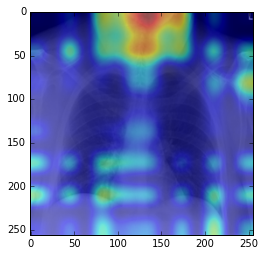

In [56]:
#Path to test images.
im_files=["/mnt/data/datasets/belnormtvt/test/TB/103.jpg","/mnt/data/datasets/belnormtvt/test/TB/187.jpg", "/mnt/data/datasets/belnormtvt/test/Normal/203-212-500-500-100.jpg","/mnt/data/datasets/belnormtvt/test/Normal/6-15-500-500-100.jpg"]
for im_file in im_files:
    img1 = image.load_img(im_file,target_size=(256,256))
    img1 = image.img_to_array(img1)
    img1 = np.expand_dims(img1, axis=0)
    img1 = preprocess_input(img1)
    layer_idx = utils.find_layer_idx(model, 'dense_2')
    heatmap = visualize_cam(model, layer_idx, filter_indices=0, seed_input=img1[0,:,:,:])
    img_init=utils.load_img(im_file,target_size=(256,256,3))
    #plt.imshow(heatmap)
    plt.imshow(overlay(img_init, heatmap))
    plt.show()

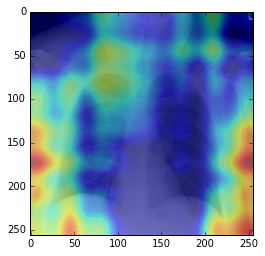

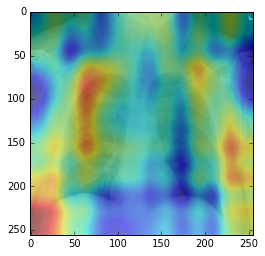

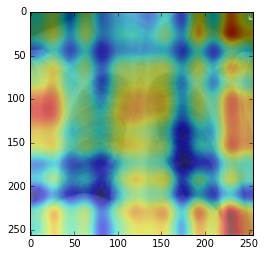

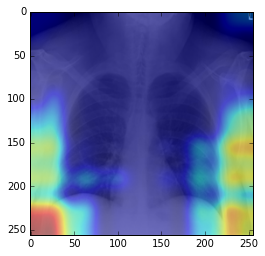

In [58]:
#Path to test images.
im_files=["/mnt/data/datasets/chnmcu256validate/TB/CHNCXR_0327_1.jpg","/mnt/data/datasets/chnmcu256validate/TB/CHNCXR_0373_1.jpg", "/mnt/data/datasets/chnmcu256validate/TB/CHNCXR_0379_1.jpg","/mnt/data/datasets/chnmcu256validate/TB/CHNCXR_0385_1.jpg"]
for im_file in im_files:
    img1 = image.load_img(im_file,target_size=(256,256))
    img1 = image.img_to_array(img1)
    img1 = np.expand_dims(img1, axis=0)
    img1 = preprocess_input(img1)
    layer_idx = utils.find_layer_idx(model, 'dense_2')
    heatmap = visualize_cam(model, layer_idx, filter_indices=None, seed_input=img1[0,:,:,:]) 
    #plt.imshow(heatmap)
    plt.imshow(overlay(img_init, heatmap))
    plt.show()

In [19]:
penultimater_layer_idx = utils.find_layer_idx(model,'mixed6')
print(penultimater_layer_idx)

196


In [ ]:
plt.imshow(heatmap)
plt.show()

In [ ]:
from keras.models import *
from keras.callbacks import *
import keras.backend as K
#from model import *
#from data import *
import cv2
import argparse


In [ ]:
def visualize_class_activation_map(model_path, img_path, output_path):
        model = load_model('tb_model.h5')
        original_img = cv2.imread(model_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 1, 0))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "mixed7")
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        for i, w in enumerate(class_weights[:, 1]):
                cam += w * conv_outputs[i, :, :]
        print "predictions", predictions
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img)
        
def get_output_layer(model, layer_name):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [ ]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--train", type = bool, default = False, help = 'Train the network or visualize a CAM')
    parser.add_argument("--image_path", type = str, help = "Path of an image to run the network on")
    parser.add_argument("--output_path", type = str, default = "heatmap.jpg", help = "Path of an image to run the network on")
    parser.add_argument("--model_path", type = str, help = "Path of the trained model")
    parser.add_argument("--dataset_path", type = str, help = \
        'Path to image dataset. Should have pos/neg folders, like in the inria person dataset. \
        http://pascal.inrialpes.fr/data/human/')
    args = parser.parse_args()
    return args

if __name__ == '__main__':
	args = get_args()
        if args.train:
                train(args.dataset_path)
        else:
                visualize_class_activation_map(args.model_path, args.image_path, args.output_path)

In [ ]:
model.summary()


In [ ]:
visualize_class_activation_map("tb_model.h5", "/mnt/data/datasets/belnormtvt/test/TB/103.jpg", "/mnt/data/keras")

In [ ]:

original_img = cv2.imread("/mnt/data/datasets/belnormtvt/test/TB/103.jpg", 1)

In [ ]:
img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])

In [ ]:
class_weights = model.layers[-1].get_weights()[0]
final_conv_layer = get_output_layer(model, "mixed7")
get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img])
#conv_outputs = conv_outputs[0, :, :, :]

In [ ]:
#mport os, signal
#os.kill(os.getpid(), signal.SIGKILL)
#print (os.getpid())

In [ ]:

def grad_cam(input_model, image, category_index, layer_name):
    model = load_model('tb_model.h5')

    nb_classes = 2
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (256, 256))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [ ]:
grad_cam(model, "/mnt/data/datasets/belnormtvt/test/TB/103.jpg", predicted_class, "mixed7")

In [ ]:
predicted_class = np.argmax(predictions)

In [ ]:
predicted_class

In [ ]:
from model import build_model, preprocessing_function, deprocess_input
import os
import cv2
from keras import activations
from keras.optimizers import SGD
from vis.utils import utils
from keras.preprocessing.image import ImageDataGenerator
from vis.visualization import visualize_cam, overlay
import numpy as np


def main():
    IMG_FOLDER = '../mnt/data/datasets/tvt1182/chnmcu256train/'
    IM_FOLDER = '../mnt/data/datasets/tvt1182/'
    shape = (256, 256)
    model = build_model(shape)

    weights_file = 'tb_model.h5'
    print("Load weights from file: ", weights_file)
    model.load_weights(weights_file, by_name=True)
    sgd = SGD(lr=0.00001, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

    data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    img_generator = data_gen.flow_from_directory(os.path.join(IMG_FOLDER, 'chnmcu256validate'),
                                                 target_size=shape,
                                                 batch_size=1,
                                                 class_mode='binary')

    print(model.summary())
    layer_idx = utils.find_layer_idx(model, 'output')
    print("layer_idx: ", layer_idx)
    penultimate_layer_idx = utils.find_layer_idx(model, 'mixed7')
    print("penultimate_layer_idx: ", penultimate_layer_idx)
    model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(model)

    class_1 = np.array([[1., 0.]], dtype=np.float32)
    class_2 = np.array([[0., 1.]], dtype=np.float32)
    for X, y in img_generator:
        if (y == class_1).all(): print("Normal")
        if (y == class_2).all(): print("TB")
        heatmap = visualize_cam(model,
                                layer_idx=layer_idx,
                                filter_indices=0,
                                seed_input=X,
                                penultimate_layer_idx=penultimate_layer_idx,
                                backprop_modifier=None,
                                grad_modifier=None)
        print("heatmap shape: ", heatmap.shape)
        cv2.imwrite('attention_map.png', overlay(heatmap[:, :, ::-1], deprocess_input(X)))
        answer = input("Continue? (y or n)\r\n")
        if 'n' in answer:
            break


if __name__ == '__main__':
    main()

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)